In [1]:
import os
import sys
import json
import torch
import importlib
import torch.nn as nn
import pandas as pd
from typing import Dict, List, Any
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Get the current working directory
scripts_dir = os.getcwd()
# Go up one level
project_root = os.path.abspath(os.path.join(scripts_dir, '..'))
sys.path.append(project_root)

import src.sc_wmmse
importlib.reload(src.sc_wmmse)
from src.sc_wmmse import WMMSE_alg_sc

# import src.utils
# importlib.reload(src.utils)
# from src.utils import calculate_sum_rate_sc

Data sample

In [2]:
class setup():
    def __init__(self, n_tx, n_rx, num_streams, num_users, PT, sig, alpha):
        self.n_tx = n_tx
        self.n_rx = n_rx
        self.d = num_streams
        self.K = num_users
        self.PT = PT
        self.sig = sig
        self.alpha = alpha

In [3]:
# The setup
num_users = 1
n_tx = 4
n_rx = [2] * num_users
d = [2] * num_users
PT = 300
sig = [1] * num_users
alpha = [1] * num_users
max_iter_alg = 1000
tol_alg = 1e-4
alpha = [1] * num_users

In [4]:
set_up = setup(n_tx, n_rx, d, num_users, PT, sig, alpha)

In [247]:
H = {str(i): torch.randn(set_up.n_rx[i], set_up.n_tx, dtype=torch.cdouble) for i in range(set_up.K)}

In [248]:
V_init = {str(i): torch.rand(set_up.n_tx, set_up.d[i], dtype=torch.cdouble) for i in range(set_up.K)}

In [42]:
def proj_power(V):
    s = torch.trace(V[str(0)] @ V[str(0)].conj().T)
    V[str(0)] = torch.sqrt(set_up.PT/s) * V[str(0)]
    return V

In [249]:
V_init_proj = proj_power(V_init)
torch.trace(V_init_proj[str(0)] @ V_init_proj[str(0)].conj().T)

tensor(300.+2.6073e-15j, dtype=torch.complex128)

sc wmmse

In [250]:
w = WMMSE_alg_sc(set_up.K, set_up.n_tx, set_up.n_rx, H, set_up.PT, set_up.sig, set_up.d, set_up.alpha, max_iter_alg, tol_alg)
V_l, U_l, W_l = w.algorithm(V_init_proj)

/Users/Ali/Projects/Deep-Unfolding-NN/src/sc_wmmse.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alph = torch.sqrt(torch.tensor(self.PT)) / torch.sqrt(torch.tensor(sum([torch.trace(V[str(k)] @ V[str(k)].conj().T) for k in range(self.K)])))


In [251]:
torch.log2(torch.linalg.det(W_l[-1][str(0)]))

tensor(16.4350-3.1882e-14j, dtype=torch.complex128)

nn

In [108]:
def calculate_sum_rate_sc(H, V, alpha, sig):
    # Calculate sum rate for single cell
    sum_rate = 0
    for k in range(len(H)):
        Nr = H[str(k)].shape[0]
        # Calculate Omega
        S = 0
        for l in range(len(H)):
            if l == k: pass
            else:
                S += H[str(k)] @ V[str(l)] @ V[str(l)].conj().T @ H[str(k)].conj().T
        S += sig[k] * torch.eye(Nr, dtype=torch.cdouble)
        tmp = torch.eye(Nr, dtype=torch.cdouble) + H[str(k)] @ V[str(k)] @ V[str(k)].conj().T @ H[str(k)].conj().T @ torch.linalg.inv(S)
        R = torch.log2(torch.linalg.det(tmp))
        sum_rate += alpha[k] * R
    return sum_rate

In [252]:
class Layer(nn.Module):
    def __init__(self, setup):
        super().__init__()
        self.setup = setup
        dict = {}
        dict[str(0)] = nn.Parameter(torch.randn(self.setup.n_tx, self.setup.d[0], dtype=torch.cdouble))
        self.V = nn.ParameterDict(dict)

    def forward(self):

        return self.V

In [257]:
# NN with adam optimizer

class Trainer:
    def __init__(self, model: Layer, setup, lr: float = 1e-3):
        self.setup = setup
        self.model = model
        self.opt = torch.optim.Adam(model.parameters(), lr=lr)

    def train_epoch(self, H, num_epochs):

        def proj_power(V):
            s = torch.trace(V[str(0)] @ V[str(0)].conj().T)
            scale = torch.sqrt(self.setup.PT / s)
            V[str(0)].mul_(scale)

        V_l = []
        for _ in range(num_epochs):
            self.model.train()
            total_loss = 0.0
            self.opt.zero_grad()
            loss = -1 * calculate_sum_rate_sc(H, self.model.V, self.setup.alpha, self.setup.sig).real

            loss.backward()

            self.opt.step()

            with torch.no_grad():
                proj_power(self.model.V)

            V_l.append(self.model.V[str(0)].detach().clone())
            total_loss += loss.item()

        return calculate_sum_rate_sc(H, self.model.V, self.setup.alpha, self.setup.sig), self.model(), V_l

In [262]:
# NN with manual update

class Trainer:
    def __init__(self, model: Layer, setup, lr: float = 1e-3):
        self.setup = setup
        self.model = model
        self.lr = lr

    def train_epoch(self, H, num_epochs):

        def proj_power(V):
            s = torch.trace(V[str(0)] @ V[str(0)].conj().T)
            scale = torch.sqrt(self.setup.PT / s)
            V[str(0)].mul_(scale)

        I = torch.eye(2, dtype=torch.cdouble)
        V_l = []
        for _ in range(num_epochs):
            self.model.train()
            total_loss = 0.0
            self.model.V[str(0)].requires_grad_(True)

            if self.model.V[str(0)].grad is not None:
                self.model.V[str(0)].grad.zero_()

            loss = -1 * calculate_sum_rate_sc(H, self.model.V, self.setup.alpha, self.setup.sig).real

            loss.backward()

            with torch.no_grad():
                self.model.V[str(0)] -= self.lr * self.model.V[str(0)].grad
                proj_power(self.model.V)

            V_l.append(self.model.V[str(0)].detach().clone())
            total_loss += loss.item()

        return calculate_sum_rate_sc(H, self.model.V, self.setup.alpha, self.setup.sig), self.model(), V_l

In [263]:
tr = Trainer(model=Layer(set_up), setup=set_up, lr=1e-2)

In [264]:
a1, a2, a3 = tr.train_epoch(H, 100000)

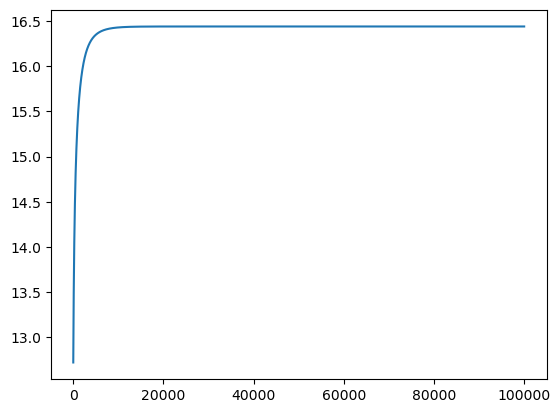

In [265]:
r_l = []
for i in a3:
    r_l.append(torch.log2(torch.linalg.det(torch.eye(2, dtype=torch.cdouble) + H['0'] @ i @ i.conj().T @ H['0'].conj().T)).real)
plt.plot(r_l)

In [266]:
max(r_l)

tensor(16.4391, dtype=torch.float64)

In [268]:
torch.trace(V_l[-1]['0'] @ V_l[-1]['0'].conj().T)

tensor(300.0000-2.0878e-15j, dtype=torch.complex128)

2 layer nn

In [495]:
class Layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.A = nn.Parameter(torch.randn(3, 3, dtype=torch.cdouble))

    def forward(self, V):

        # def proj_power(V):
        #     s = torch.trace(V[str(0)] @ V[str(0)].conj().T)
        #     V[str(0)] = torch.sqrt(self.setup.PT/s) * V[str(0)]
        #     return V

        # return proj_power(self.V)
        return self.A @ V

class DUNN(nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([
            Layer()
            for _ in range(num_layers)
        ])

    def forward(self, V):
        for layer in self.layers:
            V = layer(V)
        return V

class Trainer:
    def __init__(self, model: Layer, lr: float = 1e-3):
        self.model = model
        self.opt = torch.optim.Adam(model.parameters(), lr=lr)
        # self.opt = torch.optim.LBFGS(self.model.parameters(), lr=.1, max_iter=20, line_search_fn='strong_wolfe')


    def train_epoch(self, V, num_epochs):

        V_l = []
        for _ in range(num_epochs):
            self.model.train()
            total_loss = 0.0
            self.opt.zero_grad()
            loss = torch.trace(self.model(V).conj().T @  self.model(V)).real
            print(loss)
            loss.backward()
            # print(self.model.V[str(0)].grad)
            # print(self.model.V[str(0)])
            self.opt.step()
            # print(self.model.V[str(0)])
            # self.model.V = proj_power(self.model.V)
            # print(self.model.V[str(0)], '\n')
            # print(self.model.V[str(0)] @ self.model.V[str(0)].conj().T, '\n')
            # with torch.no_grad():
            #     proj_power(self.model.V)
            # print(torch.log2(torch.linalg.det(torch.eye(2, dtype=torch.cdouble) + H['0'] @ self.model.V[str(0)] @ self.model.V[str(0)].conj().T @ H['0'].conj().T)), '\n')
            # print(self.model.V[str(0)], '\n')
            # V_l.append(self.model.V)
            # V_l.append(self.model.V[str(0)].detach().clone())
            # total_loss += loss.item()

        # return calculate_sum_rate_sc(H, self.model.V, self.setup.alpha, self.setup.sig), self.model(), V_l

In [496]:
V = torch.randn(3, 3, dtype=torch.cdouble)

du = DUNN(num_layers=2)

tr = Trainer(model=du, lr=.01)
tr.train_epoch(V, num_epochs=100)

tensor(19.6534, dtype=torch.float64, grad_fn=<SelectBackward0>)
tensor(17.8405, dtype=torch.float64, grad_fn=<SelectBackward0>)
tensor(16.1942, dtype=torch.float64, grad_fn=<SelectBackward0>)
tensor(14.7063, dtype=torch.float64, grad_fn=<SelectBackward0>)
tensor(13.3632, dtype=torch.float64, grad_fn=<SelectBackward0>)
tensor(12.1490, dtype=torch.float64, grad_fn=<SelectBackward0>)
tensor(11.0510, dtype=torch.float64, grad_fn=<SelectBackward0>)
tensor(10.0602, dtype=torch.float64, grad_fn=<SelectBackward0>)
tensor(9.1690, dtype=torch.float64, grad_fn=<SelectBackward0>)
tensor(8.3702, dtype=torch.float64, grad_fn=<SelectBackward0>)
tensor(7.6562, dtype=torch.float64, grad_fn=<SelectBackward0>)
tensor(7.0194, dtype=torch.float64, grad_fn=<SelectBackward0>)
tensor(6.4519, dtype=torch.float64, grad_fn=<SelectBackward0>)
tensor(5.9457, dtype=torch.float64, grad_fn=<SelectBackward0>)
tensor(5.4929, dtype=torch.float64, grad_fn=<SelectBackward0>)
tensor(5.0859, dtype=torch.float64, grad_fn=<Se

pga

In [254]:
class fixed_channel_pga():

    def __init__(self, H, PT):
        self.H = H
        self.PT = PT
        self.Nr, self.Nt = H.shape
        
    def solve(self, num_iter=200000, lr=0.1):
        def proj_psd_trace(S, P):
            """Project Hermitian S onto {X ≽ 0,  tr(X) ≤ P}."""
            # Hermitian eigendecomp
            eigval, eigvec = torch.linalg.eigh(S)
            eigval.clamp_(min=0)             # PSD
            s = eigval.sum()
            if s > P:                        # scale down uniformly
                eigval *= P / s
            return (eigvec * eigval) @ eigvec.conj().T
        
        I = torch.eye(self.Nr, dtype=torch.cdouble)

        Sigma = torch.eye(self.Nt, dtype=torch.cdouble, requires_grad=True)

        for _ in range(num_iter): 
            Sigma.requires_grad_(True)
            M = I + self.H @ Sigma @ self.H.conj().T
            loss = torch.logdet(M).real
            loss.backward()
            g = Sigma.grad

            with torch.no_grad():
                Sigma = Sigma + lr * g
                Sigma = proj_psd_trace(Sigma, self.PT)

        return Sigma

In [255]:
pga = fixed_channel_pga(H['0'], 300)
sigma = pga.solve()

In [256]:
torch.log2(torch.linalg.det(torch.eye(2, dtype=torch.cdouble) + H['0'] @ sigma @ H['0'].conj().T))

tensor(16.4261-1.7270e-16j, dtype=torch.complex128)